In [1]:
import sys
import torch


sys.path.append("..")

from data import get_task, get_dataloader
from helpers import ROOT_DIR
from models.gpt2 import GPT2Editor

torch.cuda.manual_seed(42)


%env CUDA_VISIBLE_DEVICES=2
%load_ext autoreload
%autoreload 2

env: CUDA_VISIBLE_DEVICES=2


In [28]:
a = torch.tensor([[0, 0, 0, 1, 2, 3],
                  [0, 0, 4, 5, 6, 7]])
b = torch.tensor([[0, 0, 0, 0, 8, 9],
                  [0, 0, 0, 1, 2, 3]])

# Find the index of the first non-zero element in each vector
a_start = (a != 0).any(dim=0).nonzero(as_tuple=True)[0]
b_start = (b != 0).any(dim=0).nonzero(as_tuple=True)[0]

# Determine the maximum size of the output vectors
out_size = max(a.size(1) - a_start.max().item(), b.size(1) - b_start.max().item())

# Create the output tensor with zeros
out = torch.zeros(a.size(0), out_size, dtype=a.dtype)

# Create a mask for the non-padding elements of a
a_mask = torch.arange(a.size(1)).unsqueeze(0) >= a_start.unsqueeze(1)

# Create a mask for the non-padding elements of b
b_mask = torch.arange(b.size(1)).unsqueeze(0) >= b_start.unsqueeze(1)

In [41]:
(a != 0).any(dim=0)

tensor([False, False,  True,  True,  True,  True])

In [31]:
a_start, b_start

(tensor([0, 1]), tensor([0, 1]))

In [29]:
a_mask, b_mask

(tensor([[ True,  True,  True,  True,  True,  True],
         [False,  True,  True,  True,  True,  True]]),
 tensor([[ True,  True,  True,  True,  True,  True],
         [False,  True,  True,  True,  True,  True]]))

In [9]:
batch_size, k, hidden_size = 2, 3, 4

In [11]:
import torch

# Assume you have the following tensors
tensor = torch.ones(batch_size, k, hidden_size) + 1
mask = torch.tensor(
    [[0, 0, 0, 1, 1, 1], [0, 0, 1, 1, 1, 1]], dtype=torch.bool
)  # Example mask tensor

sequence_length = mask.size(1)

# Create a new tensor of shape (batch, sequence, hidden) filled with zeros
padded_tensor = torch.zeros(batch_size, sequence_length, hidden_size)

# Create a boolean mask of shape (batch, sequence) where the first k positions in each batch element are True
mask_sum = mask.cumsum(dim=1)
bool_mask = torch.logical_and(mask > 0, mask_sum <= k)


# Get the indices of the True values in the boolean mask
indices = torch.nonzero(bool_mask, as_tuple=True)

# Assign the values from the original tensor to the corresponding positions in the new tensor
padded_tensor[indices] = tensor.view(-1, hidden_size)

In [12]:
padded_tensor

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [2., 2., 2., 2.],
         [2., 2., 2., 2.],
         [2., 2., 2., 2.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [2., 2., 2., 2.],
         [2., 2., 2., 2.],
         [2., 2., 2., 2.],
         [0., 0., 0., 0.]]])

In [2]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gpt2")

tokenizer("!")

{'input_ids': [0], 'attention_mask': [1]}

In [4]:
tokenizer.eos_token_id

50256

In [2]:
def compute_position_ids(attn_mask: torch.LongTensor) -> torch.Tensor:
    unmasked_len = attn_mask.sum(-1, keepdim=True)
    position_ids = (
        torch.arange(0, attn_mask.shape[-1], device=attn_mask.device)
        .unsqueeze(0)
        .repeat(unmasked_len.shape[0], 1)
    )
    position_ids -= unmasked_len
    position_ids[position_ids < 0] = 0
    return position_ids

In [3]:
attn_mask = torch.cat((torch.zeros(2, 4), torch.ones(2, 4)), dim=-1).to(torch.long)

position_ids = compute_position_ids(attn_mask)
print(attn_mask)
print(position_ids)

tensor([[0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1]])
tensor([[0, 0, 0, 0, 0, 1, 2, 3],
        [0, 0, 0, 0, 0, 1, 2, 3]])


In [3]:
from omegaconf import DictConfig

cfg = DictConfig(
    {
        "model": {"name_or_path": "gpt2", "max_length": 512},
        "task": {
            "name": "wikipedia",
            "followup_char_limit": 500,
            "editor_token_limit": 50,
        },
        "train": {
            "train_batch_size": 1,
            "validation_batch_size": 1,
            "stop_editing_idx": 8,
        },
        "data": {
            "test_split": 0.1,
            "val_split": 0.1,
            "n_examples": 1000,
            "train_batch_size": 2,
            "val_batch_size": 2,
        },
        "seed": 42,
    }
)

ds = get_task(cfg, "wikipedia", "train")

dl = get_dataloader(ds, cfg, "train")

Map (num_proc=48):   0%|          | 0/1326278 [00:00<?, ? examples/s]

Filter (num_proc=48):   0%|          | 0/1326278 [00:00<?, ? examples/s]

Saving the dataset (0/25 shards):   0%|          | 0/1323899 [00:00<?, ? examples/s]

In [4]:
ds_no_pad = ds.filter(
    lambda x: sum(x["target_attention_mask"]) == 50
)

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [5]:
ds_no_pad

Dataset({
    features: ['title', 'first_sentence', 'second_sentence', 'third_sentence', 'editor_input_ids', 'editor_attention_mask', 'target_input_ids', 'target_attention_mask'],
    num_rows: 152
})

In [3]:
from transformers import AutoTokenizer

batch = next(iter(dl))

tok = AutoTokenizer.from_pretrained(cfg.model.name_or_path)

In [5]:
for batch in dl:
    print(
        (
            batch["target_attention_mask"].shape[-1]
            - batch["target_attention_mask"].sum(-1)
        ).item()
    )

7
8
23
4
0
12
11
6
22
23
8
25
25
2
6
12
20
26
24
24
0
5
22
17
24
0
17
19
3
0
20
10
0
19
0
28
36
6
2
22
17
21
18
13
1
5
31
36
6
0
0
26
14
0
17
14
7
23
17
31
19
0
15
37
14
24
25
0
22
15
5
13
9
27
33
22
0
0
19
21
24
21
1
4
0
26
0
17
28
30
12
4
3
9
18
16
17
29
21
22
25
8
42
14
11
14
0
32
23
15
21
15
18
23
36
4
18
11
24
9
42
24
37
0
30
20
15
8
27
31
3
20
30
14
18
0
23
15
10
2
18
24
6
24
3
6
37
9
39
17
11
13
12
0
26
12
5
36
19
0
33
8
20
24
7
28
28
0
31
19
0
13
1
21
28
27
10
31
26
6
14
12
5
16
13
1
19
15
25
6
21
7
9
27
25
0
16
16
2
19
0
1
4
12
26
9
0
24
11
16
15
36
0
10
16
0
27
15
18
12
16
24
25
0
18
16
0
33
19
35
32
0
9
8
19
21
12
3
13
0
16
30
18
27
0
34
25
0
0
0
0
15
36
9
25
0
13
2
28
14
26
33
15
24
37
7
23
8
25
30
22
22
8
25
23
16
37
14
22
26
0
20
12
9
28
13
26
21
5
10
10
0
21
14
22
4
7
29
13
2
20
10
15
13
20
8
12
5
35
15
28
4
16
26
22
23
16
20
13
28
0
24
26
0
0
36
6
0
17
0
6
13
14
0
17
0
15
35
23
27
31
9
0
4
11
11
27
23
0
2
9
1
9
27
23
15
23
28
21
6
18
0
20
7
10
15
0
1
3
28
12
5
18
21
18


In [6]:
from models.gpt2 import GPT2EditorConfig

editor_model = GPT2Editor(GPT2EditorConfig()).cuda()

In [8]:
ckpt = torch.load(
    "/home/sidnbaskaran/hypernetwork-editor/assets/checkpoints/wikipedia-full_20240512_165318/step-33157/checkpoint.pt",
    map_location="cuda:0",
)
editor_model.hypernetwork.load_state_dict(ckpt["hypernetwork"])

<All keys matched successfully>

In [ ]:
from helpers import visualize_attn_heatmap

In [26]:
from helpers import slice_and_move_batch_for_device

with torch.no_grad():
    batch = next(iter(dl))
    out = editor_model(
        **slice_and_move_batch_for_device(batch, 0, 1),
        output_target_hidden_states=True,
        output_edited_hidden_states=True,
        output_edit_vectors=True,
        output_editor_attention=True,
    )

stacking dimension is 1


Editing target: ['He', 'Ġrepresented', 'Ġhis', 'Ġcountry', 'Ġat', 'Ġthe', 'Ġ2017', 'ĠWorld']
Editor input: ['D', 'ylan', 'ĠSic', 'obo', 'Ġ(', 'born', 'Ġ27', 'ĠFebruary', 'Ġ1997', ')', 'Ġis', 'Ġa', 'ĠSe', 'y', 'chell', 'ois', 'Ġspr', 'inter', '.']
Editor preds: [' he', ' represented', ' other', ' in', ' other', ' the', ' in', ' World']


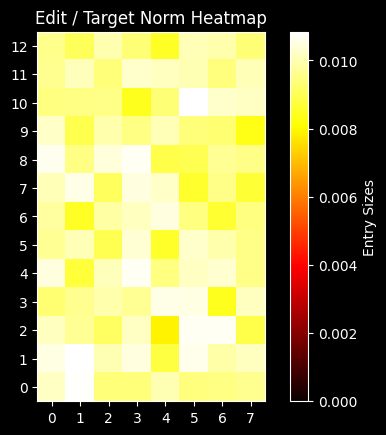

In [27]:
visualize_attn_heatmap(
    result=out,
    batch=batch,
    show_plot=True,
    tokenizer=tok,
    stopping_index=8,
)